<a href="https://colab.research.google.com/github/RitamPatra76/Fire-detection-Computer-vision-/blob/main/Fire_detection_using_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow keras numpy pandas matplotlib seaborn opencv-python tqdm scipy scikit-learn

In [ ]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

import os
import cv2
from glob import glob
from tqdm import tqdm
from scipy.stats import uniform

import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking

from mpl_toolkits.axes_grid1 import ImageGrid

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
from glob import glob

dataset_path = "/content/drive/MyDrive/fire_dataset"

fire_images = glob(os.path.join(dataset_path, "fire_images", "*.png"))
non_fire_images = glob(os.path.join(dataset_path, "non_fire_images", "*.png"))

print(f"Fire Images: {len(fire_images)}")
print(f"Non-Fire Images: {len(non_fire_images)}")

Mounted at /content/drive
Fire Images: 755
Non-Fire Images: 244


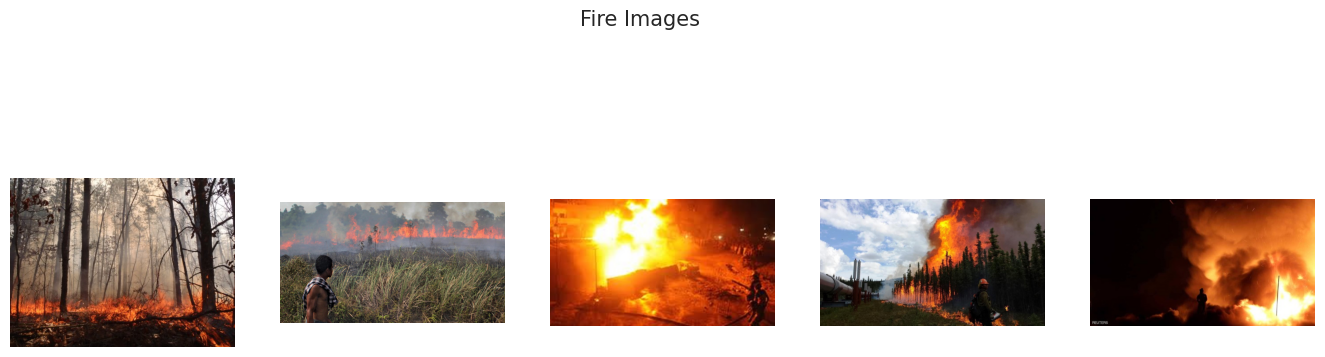

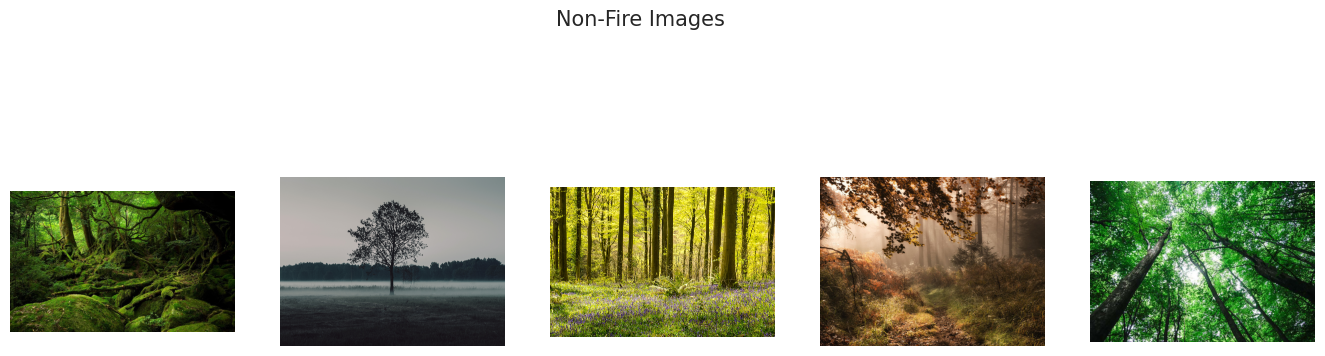

In [ ]:

def display_images(image_paths, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    fig.suptitle(title, fontsize=15)

    for i, img_path in enumerate(image_paths[:5]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].axis("off")

    plt.show()

display_images(fire_images, "Fire Images")
display_images(non_fire_images, "Non-Fire Images")


Text(0.5, 0.8, '🔥 Fire Image Processing Pipeline 🔥')

<ipython-input-7-f8e5443511d6>:35: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


Text(0.5, 1.0, 'ORIGINAL')

Text(0.5, 1.0, 'MASK')

Text(0.5, 1.0, 'SEGMENTED')

Text(0.5, 1.0, 'SHARPENED')

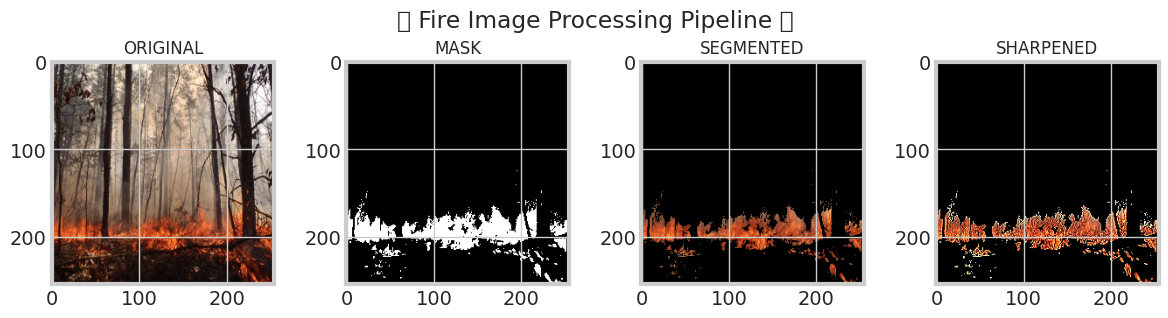

In [ ]:

def read_img(image_path, size=(255, 255)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    return img

def create_mask_for_fire(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_bound = np.array([0, 120, 120])
    upper_bound = np.array([40, 255, 255])
    mask = cv2.inRange(hsv, lower_bound, upper_bound)  # masking
    return mask

def segment_image(image):
    mask = create_mask_for_fire(image)
    segmented = cv2.bitwise_and(image, image, mask=mask)
    return segmented

def sharpen_image(image):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]], dtype=np.float32)
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

sample_image_path = fire_images[0]
img = read_img(sample_image_path, (255, 255))

image_mask = create_mask_for_fire(img)
image_segmented = segment_image(img)
image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(12, 5))
plt.suptitle('🔥 Fire Image Processing Pipeline 🔥', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPENED', fontsize=12)

ax[0].imshow(img)
ax[1].imshow(image_mask, cmap='gray')
ax[2].imshow(image_segmented)
ax[3].imshow(image_sharpen)

plt.show()


In [ ]:
def analyze_fire_spread(image_data, intensity_threshold=150):
    height, width, _ = image_data.shape
    fire_regions = []

    for y in range(0, height, 5):
        for x in range(0, width, 5):
            pixel = image_data[y, x]
            intensity = sum(pixel) / 3

            if intensity > intensity_threshold:
                fire_regions.append((x, y, intensity))

    spread_rate = len(fire_regions) / (height * width)
    risk_factor = spread_rate * 100

    return {
        "fire_regions_detected": len(fire_regions),
        "spread_rate": round(spread_rate, 4),
        "risk_factor": round(risk_factor, 2),
    }

dummy_image = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)
fire_analysis = analyze_fire_spread(dummy_image)


In [ ]:
fire_labels = np.ones(len(fire_images))
non_fire_labels = np.zeros(len(non_fire_images))

X = np.array(fire_images + non_fire_images)
y = np.array(list(fire_labels) + list(non_fire_labels))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training Samples: {len(X_train)}, Testing Samples: {len(X_test)}")


Training Samples: 799, Testing Samples: 200


In [ ]:
model = Sequential([
    Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,123,881 (80.58 MB)

 Trainable params: 21,069,353 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
def preprocess_images(image_paths):
    IMG_SIZE = (224, 224)
    processed_images = []

    for img_path in tqdm(image_paths):
        img = image.load_img(img_path, target_size=IMG_SIZE)
        img_array = image.img_to_array(img) / 255.0
        processed_images.append(img_array)

    return np.array(processed_images)

X_train_processed = preprocess_images(X_train)
X_test_processed = preprocess_images(X_test)

history = model.fit(X_train_processed, y_train, validation_data=(X_test_processed, y_test), epochs=10, batch_size=16)


100%|██████████| 200/200 [01:04<00:00,  3.11it/s]


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 102s 952ms/step - accuracy: 0.9106 - loss: 0.2692 - val_accuracy: 0.8200 - val_loss: 1.1772
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - accuracy: 0.9587 - loss: 0.1739 - val_accuracy: 0.8200 - val_loss: 1.5765
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - accuracy: 0.9666 - loss: 0.0827 - val_accuracy: 0.9550 - val_loss: 0.6447
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.9883 - loss: 0.0513 - val_accuracy: 0.9500 - val_loss: 1.6073
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 250ms/step - accuracy: 0.9781 - loss: 0.0858 - val_accuracy: 0.9500 - val_loss: 0.1386
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step - accuracy: 0.9867 - loss: 0.0617 - val_accuracy: 0.9450 - val_loss: 0.1991
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 252ms/step - accuracy: 0.9909 - loss: 0.0301 - val_accuracy: 0.9350 - val_loss: 0.5528
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - accuracy: 0.9897 - loss: 0.0293 - val_acc

<Figure size 1200x500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Loss Curve')

<Axes: >

Text(0.5, 1.0, 'Accuracy Curve')

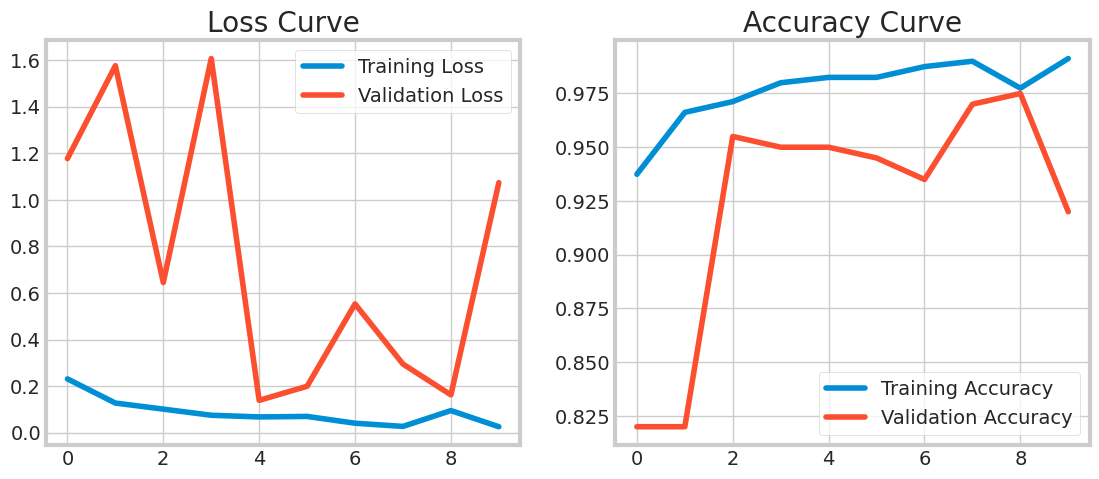

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Curve")

plt.show()

In [ ]:
X_test_processed = preprocess_images(X_test)
y_pred = (model.predict(X_test_processed) > 0.5).astype("int32")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

100%|██████████| 200/200 [00:04<00:00, 46.72it/s]


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 578ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.71      0.81        49
         1.0       0.91      0.99      0.95       151

    accuracy                           0.92       200
   macro avg       0.93      0.85      0.88       200
weighted avg       0.92      0.92      0.92       200

Confusion Matrix:
 [[ 35  14]
 [  2 149]]
Accuracy Score: 0.92
